In [1]:
import pandas as pd
import geopandas as gpd
import geodatasets
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import terracotta.gis as gis
import importlib
importlib.reload(tct)
import matplotlib.pyplot as plt
import numpy as np


# Elevation
from matplotlib.colors import LinearSegmentedColormap
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio import transform
from rasterio.plot import show
import rioxarray
import xarray
import rasterstats

# Trees
import tszip

In [2]:
gdf_h3 = gis.tile_shapefile(geodatasets.get_url("naturalearth land"), resolution=2, subset={"index":[112]})
gdf_h3.explore()

In [3]:
gdf_h3_clean = gdf_h3.drop([85,84,184,177,176,372,721,720]) #drop these because of antimeridian or disconnected
gdf_h3_clean.explore()

/opt/anaconda3/envs/terracotta/lib/python3.12/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


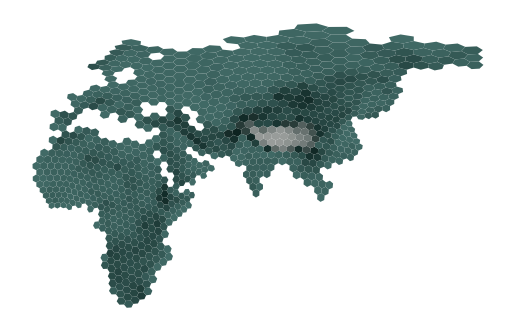

In [4]:
xds = xarray.open_dataset("dataset/starting_files/elevation/ETOPO2v2c_f4.nc")
xds["z"].rio.to_raster("dataset/starting_files/elevation/world_elevation.tif")

with rasterio.open("dataset/starting_files/elevation/world_elevation.tif") as src_dst:
    with WarpedVRT(
        src_dst,
        src_crs=src_dst.gcps[1],
        src_transform=transform.from_gcps(src_dst.gcps[0]),
    ) as vrt:
        mean_elev = []
        for stat in rasterstats.zonal_stats(
            gdf_h3_clean,
            vrt.read(1),
            affine=vrt.transform,
            stats="mean"
        ):
            mean_elev.append(stat["mean"])
        gdf_h3_clean["mean_elev"] = mean_elev

colors = ["#416A66", "#0C2320", "#989C9A"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

gdf_h3_clean.plot(column="mean_elev", cmap=cmap1, vmin=0)
plt.axis("off")
plt.show()

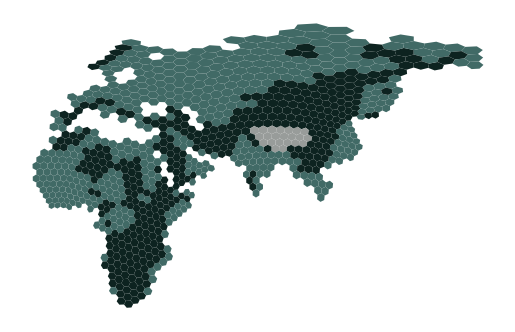

In [5]:
bins = [-10000, 500, 4000, 10000]
gdf_h3_clean["binned_elev"] = np.searchsorted(bins, gdf_h3_clean["mean_elev"].values)
gdf_h3_clean.plot(column="binned_elev", cmap=cmap1, vmin=1)
plt.axis("off")
plt.show()

In [7]:
sample_locs = pd.read_csv("dataset/starting_files/sample_locations.csv")
sample_locs = gpd.GeoDataFrame(sample_locs, geometry=gpd.GeoSeries.from_xy(sample_locs["lon"], sample_locs["lat"]), crs=4326)
sample_locs_with_region = gpd.sjoin(sample_locs, gdf_h3_clean, how="inner", predicate="within").loc[:, ["id", "deme"]]
sample_locs_with_region = sample_locs_with_region.drop_duplicates("deme")
regions_with_samples = sample_locs_with_region["deme"].unique()

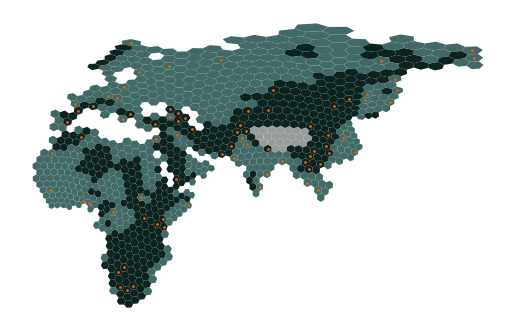

In [8]:
deme_sample_counts = sample_locs_with_region.value_counts("deme").reset_index()

base = gdf_h3_clean.plot(column="binned_elev", cmap=cmap1, vmin=1)
for i,row in gdf_h3.iterrows():
    count = sum(deme_sample_counts.loc[deme_sample_counts["deme"]==row["deme"], "count"])
    if count > 0:
        center = row["geometry"].centroid
        plt.scatter(center.x, center.y, s=count, color="#E95E0D")
plt.axis("off")
plt.show()

In [9]:
gdf_h3_clean_buffered = gdf_h3_clean.copy()
gdf_h3_clean_buffered["geometry"] = gdf_h3_clean_buffered.buffer(0.1)
with open("dataset/demes.tsv", "w") as outfile:
    outfile.write("id\txcoord\tycoord\ttype\tneighbours\n")
    for i, row in gdf_h3_clean_buffered.iterrows():
        neighbors = np.array(gdf_h3_clean_buffered[gdf_h3_clean_buffered.geometry.touches(row['geometry'])].deme)
        #overlapping neighbors use if discrepances found with touches
        overlap = np.array(gdf_h3_clean_buffered[gdf_h3_clean_buffered.geometry.overlaps(row['geometry'])].deme)
        neighbors = [str(d) for d in np.sort(np.union1d(neighbors, overlap))]
        center = row["geometry"].centroid
        outfile.write(f"{row["deme"]}\t{center.x}\t{center.y}\t{row["binned_elev"]-1}\t{",".join(neighbors)}\n")

/var/folders/q8/b10jdgls4xvcv3wz767kf6f80000gn/T/ipykernel_69166/3234729361.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_h3_clean_buffered["geometry"] = gdf_h3_clean_buffered.buffer(0.1)


In [10]:
ts = tszip.load("dataset/starting_files/hgdp_tgp_sgdp_high_cov_ancients_chr17_p.dated.trees.tsz")
ts, map_nodes = ts.simplify(samples=sample_locs_with_region["id"], map_nodes=True)

In [11]:
sample_locs_with_region["orig_id"] = sample_locs_with_region["id"]
sample_locs_with_region["id"] = map_nodes[sample_locs_with_region["id"]]
sample_locs_with_region.to_csv("dataset/samples.tsv", sep="\t", index=False)

In [13]:
tct.create_trees_folder_from_ts(ts, output_path="dataset", gap_between_trees=375)